# Deep RL

1. inputs need to reflect position in arena and odor (NOT CONJUNCTIONS)
2. outputs need to reflect action values
3. actions are selected via softmax on output neuron activity. 
4. RPE requires knowing value of new state
   -- so this will require a forward pass using "new state" inputs.

## Dependencies

In [1]:
import numpy as np
# from numpy.random import default_rng
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns

In [2]:
from utils import Params
from env.RandomWalk1D import RandomWalk1D, Actions
from agent import DQN, EpsilonGreedy
from deep_learning import Network

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_theme(font_scale=1.5)
mpl.rcParams["font.family"] = ["Fira Sans", "sans-serif"]

## Parameters

In [5]:
p = Params(
    seed=42,
    n_runs=3,
    total_episodes=200,
    epsilon=0.1,
    alpha=0.3,
    gamma=0.95,
    learning_rate=0.001,
    nLayers=3,
    nHiddenUnits=5,
)
p

Params(seed=42, rng=None, n_runs=3, total_episodes=200, epsilon=0.1, gamma=0.95, alpha=0.3, jointRep=True, learning_rate=0.001, nLayers=3, nHiddenUnits=5, action_size=None, state_size=None)

In [6]:
# # Set the seed
# p.rng = np.random.default_rng(p.seed)

## The environment

In [7]:
env = RandomWalk1D()

In [8]:
p.action_size = len(env.action_space)
p.state_size = len(env.observation_space)
print(f"Action size: {p.action_size}")
print(f"State size: {p.state_size}")

Action size: 2
State size: 7


## Running the environment

In [9]:
net = Network(
    nInputUnits=1,
    nLayers=p.nLayers,
    nOutputUnits=p.action_size,
    nHiddenUnits=p.nHiddenUnits,
)

In [10]:
[layer.shape for layer in net.wtMatrix]

[(1, 5), (5, 2)]

In [11]:
learner = DQN(
    learning_rate=p.alpha,
    gamma=p.gamma,
    state_size=p.state_size,
    action_size=p.action_size,
)

In [12]:
explorer = EpsilonGreedy(epsilon=p.epsilon, rng=p.rng)

### Main loop

In [13]:
rewards = np.zeros((p.total_episodes, p.n_runs))
steps = np.zeros((p.total_episodes, p.n_runs))
episodes = np.arange(p.total_episodes)
all_states = []
all_actions = []
X = np.array([])
y = np.array([])

for run in range(p.n_runs):  # Run several times to account for stochasticity
    learner.reset(
        action_size=env.numActions
    )  # Reset the Q-table and the weights between runs

    for episode in tqdm(episodes, desc=f"Run {run}/{p.n_runs} - Episodes", leave=False):
        state = env.reset()  # Reset the environment
        step = 0
        done = False
        total_rewards = 0

        while not done:
            # Obtain Q-values from network
            q_values = net.forward_pass(x_obs=[state])[-1]

            action = explorer.choose_action(
                action_space=env.action_space, state=state, q_values=q_values
            )

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action)

            # Obtain Q-value for selected action
            q_value = q_values[action]

            # Select next action with highest Q-value
            if new_state == done:
                new_q_value = 0  # No Q-value for terminal
            else:
                new_q_values = net.forward_pass(x_obs=[new_state])[
                    -1
                ]  # No gradient computation
                # TODO: Take a random action in case of
                new_action = np.argmax(new_q_values)
                new_q_value = new_q_values[new_action]

            # Compute observed Q-value
            q_update = reward + (learner.gamma * new_q_value)

            # # Compute loss value
            # loss = (q_update-q_value)**2

            # Update X and y for supervised learning
            if X.size == 0:
                X = np.array([state])[np.newaxis, :]
            else:
                X = np.append(X, np.array([state])[np.newaxis, :], axis=0)
            if y.size == 0:
                y = np.array([q_update])[np.newaxis, :]
            else:
                y = np.append(y, np.array([q_update])[np.newaxis, :])

            # Compute gradients and apply gradients to update network weights
            allError, y_hat, delta, activity = net.backprop(
                X=X, y=y, nLayers=p.nLayers, learning_rate=p.learning_rate
            )

            # Log all states and actions
            all_states.append(state)
            all_actions.append(action)

            total_rewards += reward
            step += 1

            # Update the state
            state = new_state

        # Log all rewards and steps
        rewards[episode, run] = total_rewards
        steps[episode, run] = step

## Visualization

In [14]:
def postprocess(episodes, p, rewards, steps):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=p.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    # res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    return res

In [15]:
res = postprocess(episodes, p, rewards, steps)
res

,Episodes,Rewards,Steps
0,0,-1.0,5.0
1,1,-1.0,3.0
2,2,-1.0,3.0
3,3,-1.0,3.0
4,4,-1.0,3.0
...,...,...,...
595,195,1.0,5.0
596,196,1.0,5.0
597,197,1.0,3.0
598,198,1.0,3.0


As a sanity check, we will plot the distributions of states and actions
with the following function:

In [16]:
def plot_states_actions_distribution(states, actions):
    """Plot the distributions of states and actions."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    sns.histplot(data=states, ax=ax[0])
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(
        [item.value for item in Actions], labels=[item.name for item in Actions]
    )
    ax[1].set_title("Actions")
    fig.tight_layout()
    plt.show()

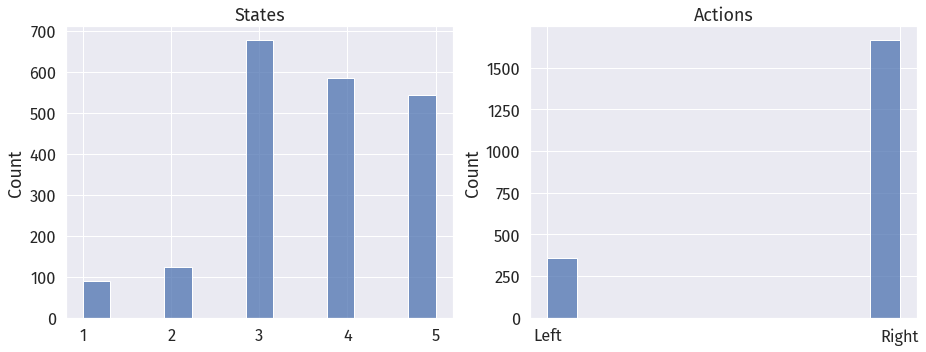

In [17]:
plot_states_actions_distribution(all_states, all_actions)

In [18]:
def plot_steps_and_rewards(df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=df, x="Episodes", y="Rewards", ax=ax[0])
    ax[0].set(ylabel=f"Rewards\naveraged over {p.n_runs} runs")

    sns.lineplot(data=df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(ylabel=f"Steps number\naveraged over {p.n_runs} runs")

    fig.tight_layout()
    plt.show()

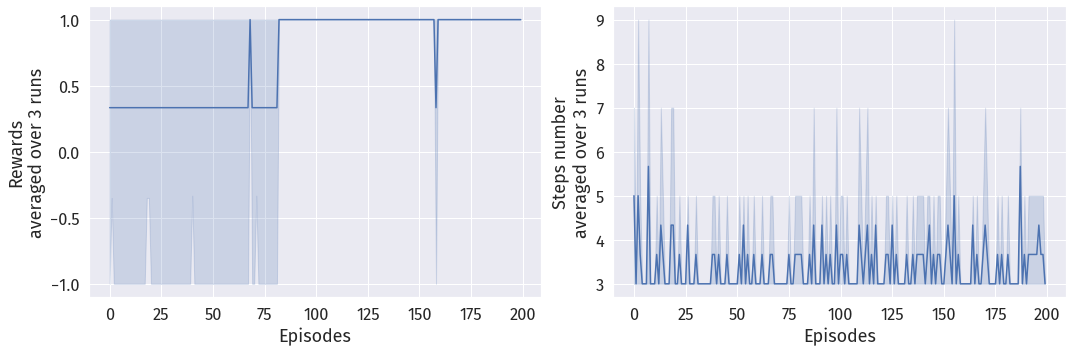

In [19]:
plot_steps_and_rewards(res)

In [20]:
q_values = np.nan * np.empty((p.state_size, p.action_size))
for state_i, state_v in enumerate(np.arange(p.state_size)):
    q_values[state_i,] = net.forward_pass(x_obs=[state_v])[-1]
q_values

array([[0.94739868, 0.85995905],
       [0.71634955, 0.75232282],
       [0.73392602, 0.78428853],
       [0.74760196, 0.80143415],
       [0.75269414, 0.80828505],
       [0.75445643, 0.81089788],
       [0.75505506, 0.81188126]])

In [21]:
q_values.flatten()[np.newaxis, :]

array([[0.94739868, 0.85995905, 0.71634955, 0.75232282, 0.73392602,
        0.78428853, 0.74760196, 0.80143415, 0.75269414, 0.80828505,
        0.75445643, 0.81089788, 0.75505506, 0.81188126]])

In [22]:
def plot_q_values(q_values):
    fig, ax = plt.subplots(figsize=(15, 1.5))
    cmap = sns.color_palette("vlag", as_cmap=True)
    chart = sns.heatmap(
        q_values.flatten()[np.newaxis, :],
        annot=True,
        ax=ax,
        cmap=cmap,
        yticklabels=False,  # linewidth=0.5
        center=0,
    )
    states_nodes = np.arange(1, 14, 2)
    chart.set_xticks(states_nodes)
    chart.set_xticklabels([str(item) for item in np.arange(0, 7, 1)])
    chart.set_title("Q values")
    ax.tick_params(bottom=True)

    # Add actions arrows
    for node in states_nodes:
        arrows_left = {"x_tail": node, "y_tail": 1.4, "x_head": node - 1, "y_head": 1.4}
        arrow = mpatches.FancyArrowPatch(
            (arrows_left["x_tail"], arrows_left["y_tail"]),
            (arrows_left["x_head"], arrows_left["y_head"]),
            mutation_scale=10,
            clip_on=False,
            color="k",
        )
        ax.add_patch(arrow)
        arrows_right = {
            "x_tail": node,
            "y_tail": 1.4,
            "x_head": node + 1,
            "y_head": 1.4,
        }
        arrow = mpatches.FancyArrowPatch(
            (arrows_right["x_tail"], arrows_right["y_tail"]),
            (arrows_right["x_head"], arrows_right["y_head"]),
            mutation_scale=10,
            clip_on=False,
            color="k",
        )
        ax.add_patch(arrow)

        # Add rectangle to separate each state pair
        rect = mpatches.Rectangle(
            (node - 1, 0),
            2,
            1,
            linewidth=2,
            edgecolor="k",
            facecolor="none",
            clip_on=False,
        )
        ax.add_patch(rect)

    plt.show()

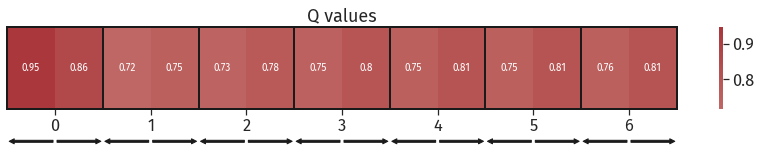

In [23]:
plot_q_values(q_values)